Classification pipeline from cuts to decision tree 

1. plot q2 vs invariant mass
2. do hard cuts (from literature, investigate whether other cuts are necessary) 
3. apply hard cuts on simulated data 
4. train GBDT on simulated data 
5. classify hard-cut data (total_dataset and acceptance)
6. investigate fraction of misclassified decays 

## import modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

In [3]:
import scipy as sp
import scipy.stats as sps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
def hist_point(a, bins, range=None, *args, **kwargs):
    # histogram but plot as scatterplot 
    hist, bin_edges = np.histogram(a, bins=bins, range=range)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.scatter(bin_centres, hist, *args, **kwargs)

## import data

In [5]:
data_path = '../data/'

total_path = f'{data_path}total_dataset.pkl'
signal_path = f'{data_path}signal.pkl'
jpsi_path = f'{data_path}jpsi.pkl' 
psi2S_path = f'{data_path}psi2S.pkl' 
jpsi_mu_k_swap_path = f'{data_path}jpsi_mu_k_swap.pkl' 
jpsi_mu_pi_swap_path = f'{data_path}jpsi_mu_pi_swap.pkl' 
k_pi_swap_path = f'{data_path}k_pi_swap.pkl' 
phimumu_path = f'{data_path}phimumu.pkl' 
pKmumu_piTok_kTop_path = f'{data_path}pKmumu_piTok_kTop.pkl' 
pKmumu_piTop_path = f'{data_path}pKmumu_piTop.pkl' 

In [6]:
total_dataset      = pd.read_pickle(total_path)
signal             = pd.read_pickle(signal_path)
jpsi               = pd.read_pickle(jpsi_path)
psi2S              = pd.read_pickle(psi2S_path)
jpsi_mu_k_swap     = pd.read_pickle(jpsi_mu_k_swap_path)
jpsi_mu_pi_swap    = pd.read_pickle(jpsi_mu_pi_swap_path)
k_pi_swap          = pd.read_pickle(k_pi_swap_path)
phimumu            = pd.read_pickle(phimumu_path)
pKmumu_piTok_kTop  = pd.read_pickle(pKmumu_piTok_kTop_path)
pKmumu_piTop       = pd.read_pickle(pKmumu_piTop_path)

In [7]:
all_datasets = [total_dataset, signal, jpsi, psi2S, jpsi_mu_k_swap, jpsi_mu_pi_swap, 
                    k_pi_swap, phimumu, pKmumu_piTok_kTop, pKmumu_piTop]
all_names = ['Total', 'Signal', 'J/Psi', 'Psi(2S)', 'J/Psi_mu/k', 'J/Psi_mu/pi', 
            'K0_k/pi', 'Phi_mu_mu', 'pK_pi/K_k/pi', 'pK_p/pi']

## general information

Total has 	 498245 datapoints
Signal has 	 255741 datapoints
J/Psi has 	 786776 datapoints
Psi(2S) has 	 181076 datapoints
J/Psi_mu/k has 	 1986 datapoints
J/Psi_mu/pi has 	 773 datapoints
K0_k/pi has 	 133292 datapoints
Phi_mu_mu has 	 68318 datapoints
pK_pi/K_k/pi has 	 1447 datapoints
pK_p/pi has 	 1127 datapoints


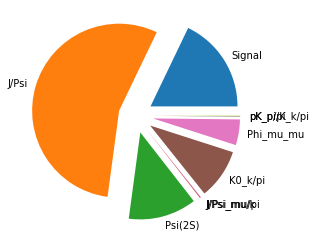

In [8]:
for name, data in zip(all_names, all_datasets):
    print(f'{name} has \t {len(data)} datapoints')

plt.pie([len(d) for d in all_datasets[1:]], labels=all_names[1:], explode=[0.2]*(len(all_datasets)-1));

## initial plots

In [9]:
def plot_q2_m_inv(data, set_range=True):
    if set_range:
        m_inv_range = [np.percentile(data['B0_MM'], 1), np.percentile(data['B0_MM'], 99)]
        q2_range = [0, 20]
        print('m_inv range', m_inv_range)
        print('q2_range', q2_range)
        
    h, x_edges, y_edges, _ = plt.hist2d(data['B0_MM'], data['q2'], 
                                        bins=100, range=[m_inv_range, q2_range] if set_range else None,
                                        norm=mpl.colors.LogNorm())

    plt.xlabel(r'$m(K^+ \pi^- \mu^+ \mu^-)$ [MeV/$c^2$]')
    plt.ylabel(r'$q^2$ [$GeV^2/c^4$]')
    

def plot_q2_mK0(data, set_range=True):
    if set_range:
        m_inv_range = [np.percentile(data['Kstar_MM'], 1), np.percentile(data['Kstar_MM'], 99)]
        q2_range = [0, 20]
        print('m(Kstar) range', m_inv_range)
        print('q2_range', q2_range)
        
    h, x_edges, y_edges, _ = plt.hist2d(data['Kstar_MM'], data['q2'], 
                                        bins=100, range=[m_inv_range, q2_range] if set_range else None,
                                        norm=mpl.colors.LogNorm())

    plt.xlabel(r'$m(K^{*0})$ [MeV/$c^2$]')
    plt.ylabel(r'$q^2$ [$GeV^2/c^4$]')

m_inv range [5173.623210452642, 5656.614283847155]
q2_range [0, 20]


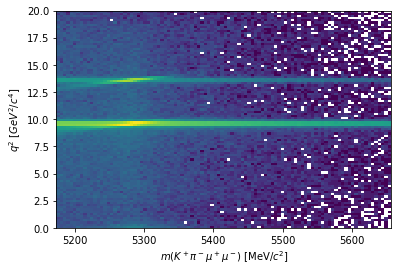

In [10]:
plot_q2_m_inv(total_dataset)

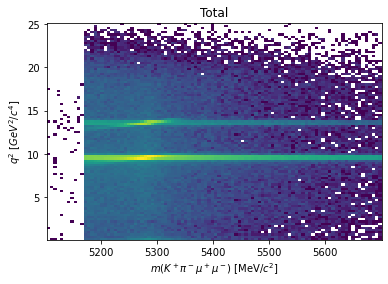

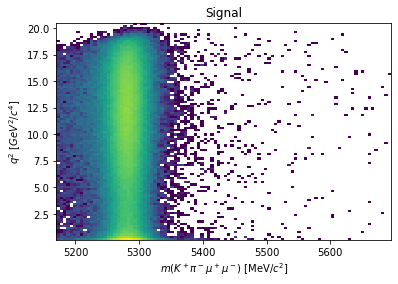

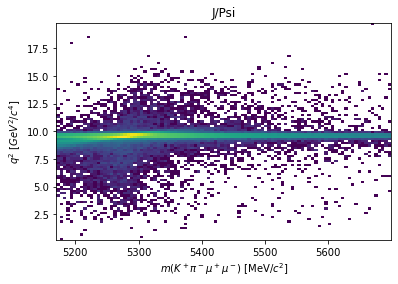

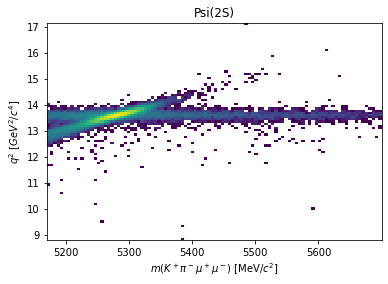

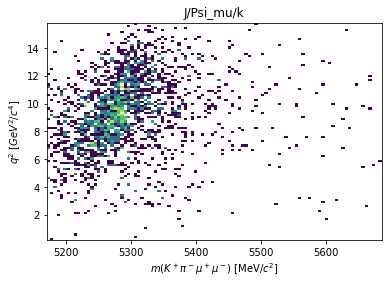

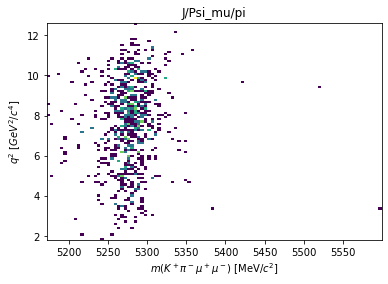

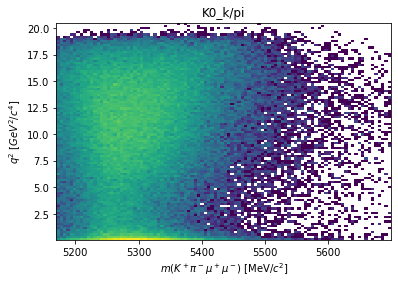

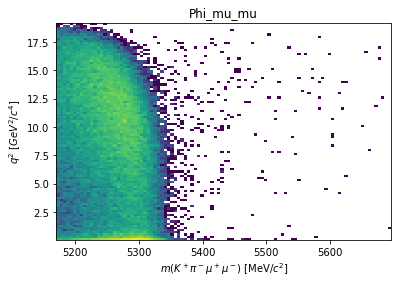

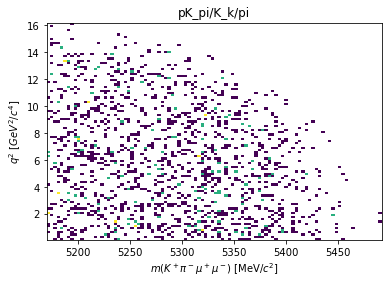

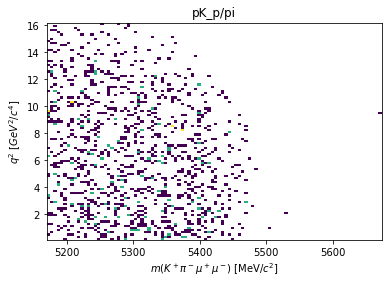

In [11]:
for name, data in zip(all_names, all_datasets):
    plot_q2_m_inv(data, set_range=False)
    plt.title(name)
    plt.show()

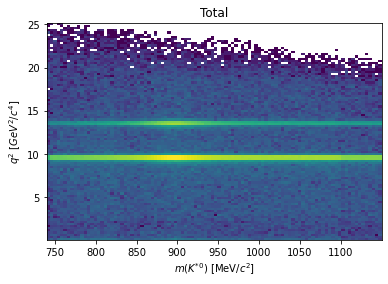

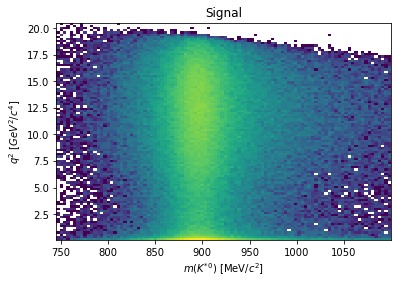

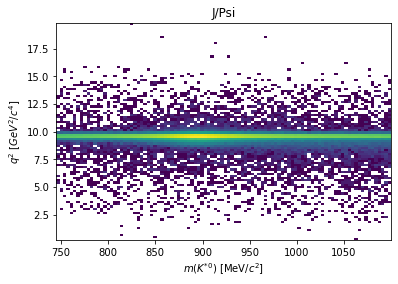

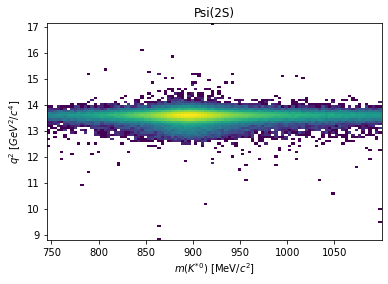

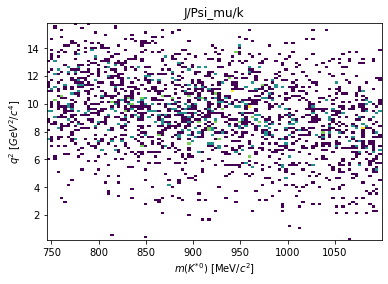

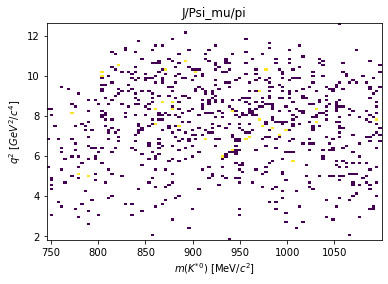

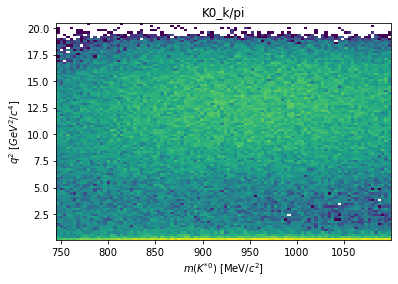

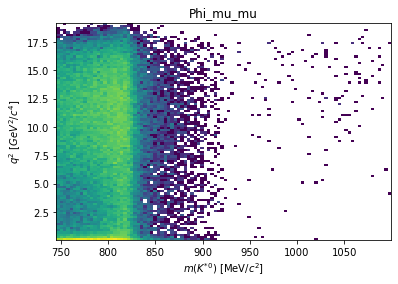

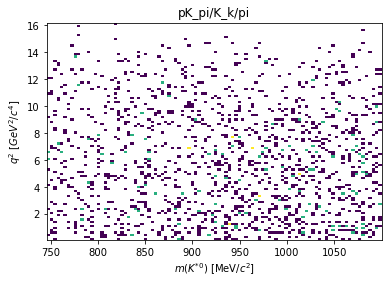

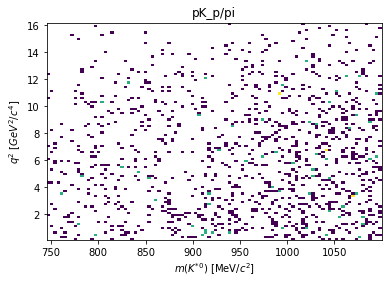

In [12]:
for name, data in zip(all_names, all_datasets):
    plot_q2_mK0(data, set_range=False)
    plt.title(name)
    plt.show()

Above plots show potential cuts and regions where specific decays are located. It is clear that most of J/Psi and Psi(2S) can be removed by cuts in q2. 

## hard cuts 

The following cuts were created by Zhihao Zhang

1. explain specific hard cut 
2. plot effect on q2 vs m_inv
3. quantify reduction in samples 
4. apply cut to total_dataset

In [13]:
from selection_criteria.functions import selection_1, selection_2, selection_3, selection_4, selection_5, selection_6

In [14]:
def benchmark_cut(cut_func):
    for name, data in zip(all_names, all_datasets):
        N_before = len(data)
        data_cut = cut_func(data)
        N_after = len(data_cut)
        
        name_space = "".join([" "]*(12-len(name)))
        N_diff = N_before - N_after
        N_frac = N_diff / N_before
        print(f'{name}{name_space} reduced by {N_frac*100:.2f}% or {N_diff} samples \tfrom {N_before} to {N_after}')

### selection 1

P(mu/K/pi == mu/K/pi) > 0.5 (non-optimised)

goal: keep reduction in signal <0.5%

In [15]:
# original, all 0.5
benchmark_cut(selection_1)

Total        reduced by 66.77% or 332699 samples 	from 498245 to 165546
Signal       reduced by 17.48% or 44711 samples 	from 255741 to 211030
J/Psi        reduced by 48.33% or 380273 samples 	from 786776 to 406503
Psi(2S)      reduced by 17.23% or 31197 samples 	from 181076 to 149879
J/Psi_mu/k   reduced by 99.80% or 1982 samples 	from 1986 to 4
J/Psi_mu/pi  reduced by 95.60% or 739 samples 	from 773 to 34
K0_k/pi      reduced by 99.84% or 133080 samples 	from 133292 to 212
Phi_mu_mu    reduced by 95.99% or 65577 samples 	from 68318 to 2741
pK_pi/K_k/pi reduced by 98.76% or 1429 samples 	from 1447 to 18
pK_p/pi      reduced by 96.01% or 1082 samples 	from 1127 to 45


In [16]:
# optimise mu
selection_1_modified = partial(selection_1, cutoff_mu=0.5, cutoff_K=0, cutoff_Pi=0)
benchmark_cut(selection_1_modified)

Total        reduced by 3.07% or 15278 samples 	from 498245 to 482967
Signal       reduced by 0.97% or 2470 samples 	from 255741 to 253271
J/Psi        reduced by 1.53% or 12059 samples 	from 786776 to 774717
Psi(2S)      reduced by 0.84% or 1512 samples 	from 181076 to 179564
J/Psi_mu/k   reduced by 79.61% or 1581 samples 	from 1986 to 405
J/Psi_mu/pi  reduced by 39.97% or 309 samples 	from 773 to 464
K0_k/pi      reduced by 0.98% or 1303 samples 	from 133292 to 131989
Phi_mu_mu    reduced by 1.07% or 734 samples 	from 68318 to 67584
pK_pi/K_k/pi reduced by 0.97% or 14 samples 	from 1447 to 1433
pK_p/pi      reduced by 1.15% or 13 samples 	from 1127 to 1114


In [17]:
# optimise K
selection_1_modified = partial(selection_1, cutoff_mu=0, cutoff_K=0.08, cutoff_Pi=0)
benchmark_cut(selection_1_modified)

Total        reduced by 50.58% or 252008 samples 	from 498245 to 246237
Signal       reduced by 2.57% or 6574 samples 	from 255741 to 249167
J/Psi        reduced by 34.10% or 268329 samples 	from 786776 to 518447
Psi(2S)      reduced by 2.98% or 5401 samples 	from 181076 to 175675
J/Psi_mu/k   reduced by 93.81% or 1863 samples 	from 1986 to 123
J/Psi_mu/pi  reduced by 1.42% or 11 samples 	from 773 to 762
K0_k/pi      reduced by 91.69% or 122211 samples 	from 133292 to 11081
Phi_mu_mu    reduced by 1.57% or 1072 samples 	from 68318 to 67246
pK_pi/K_k/pi reduced by 56.74% or 821 samples 	from 1447 to 626
pK_p/pi      reduced by 1.42% or 16 samples 	from 1127 to 1111


In [18]:
# optimise Pi
selection_1_modified = partial(selection_1, cutoff_mu=0, cutoff_K=0, cutoff_Pi=0.2)
benchmark_cut(selection_1_modified)

Total        reduced by 28.35% or 141244 samples 	from 498245 to 357001
Signal       reduced by 1.40% or 3576 samples 	from 255741 to 252165
J/Psi        reduced by 29.73% or 233917 samples 	from 786776 to 552859
Psi(2S)      reduced by 1.27% or 2305 samples 	from 181076 to 178771
J/Psi_mu/k   reduced by 1.81% or 36 samples 	from 1986 to 1950
J/Psi_mu/pi  reduced by 69.08% or 534 samples 	from 773 to 239
K0_k/pi      reduced by 83.54% or 111350 samples 	from 133292 to 21942
Phi_mu_mu    reduced by 86.36% or 58998 samples 	from 68318 to 9320
pK_pi/K_k/pi reduced by 82.93% or 1200 samples 	from 1447 to 247
pK_p/pi      reduced by 87.05% or 981 samples 	from 1127 to 146


In [19]:
# selection_1_modified = partial(selection_1, cutoff_mu=0.3, cutoff_K=0.02, cutoff_Pi=0.08)
selection_1_modified = partial(selection_1, cutoff_mu=0.5, cutoff_K=0.1, cutoff_Pi=0.4)
benchmark_cut(selection_1_modified)

Total        reduced by 59.84% or 298172 samples 	from 498245 to 200073
Signal       reduced by 7.39% or 18891 samples 	from 255741 to 236850
J/Psi        reduced by 40.97% or 322379 samples 	from 786776 to 464397
Psi(2S)      reduced by 7.51% or 13590 samples 	from 181076 to 167486
J/Psi_mu/k   reduced by 98.69% or 1960 samples 	from 1986 to 26
J/Psi_mu/pi  reduced by 92.24% or 713 samples 	from 773 to 60
K0_k/pi      reduced by 98.50% or 131299 samples 	from 133292 to 1993
Phi_mu_mu    reduced by 93.09% or 63600 samples 	from 68318 to 4718
pK_pi/K_k/pi reduced by 94.82% or 1372 samples 	from 1447 to 75
pK_p/pi      reduced by 93.88% or 1058 samples 	from 1127 to 69


Summary: Seems pretty good, but also reduces the signal by a bit.

In [20]:
# selection_1_final = partial(selection_1, cutoff_mu=0.3, cutoff_K=0.02, cutoff_Pi=0.04)
# selection_1_final = partial(selection_1, cutoff_mu=0.5, cutoff_K=0.1, cutoff_Pi=0.4)
selection_1_final = partial(selection_1, cutoff_mu=0.3, cutoff_K=0.08, cutoff_Pi=0.2) # reduced severity of this cut

### selection 2

DIRA angle > 1 - $\theta_\mathrm{thresh}^2 / 2$  

In [21]:
benchmark_cut(selection_2)

Total        reduced by 0.21% or 1060 samples 	from 498245 to 497185
Signal       reduced by 0.04% or 96 samples 	from 255741 to 255645
J/Psi        reduced by 0.05% or 429 samples 	from 786776 to 786347
Psi(2S)      reduced by 0.03% or 59 samples 	from 181076 to 181017
J/Psi_mu/k   reduced by 0.05% or 1 samples 	from 1986 to 1985
J/Psi_mu/pi  reduced by 0.00% or 0 samples 	from 773 to 773
K0_k/pi      reduced by 0.04% or 53 samples 	from 133292 to 133239
Phi_mu_mu    reduced by 0.05% or 31 samples 	from 68318 to 68287
pK_pi/K_k/pi reduced by 0.00% or 0 samples 	from 1447 to 1447
pK_p/pi      reduced by 0.00% or 0 samples 	from 1127 to 1127


In [22]:
selection_2_modified = partial(selection_2, threshold_angle=10e-3)
benchmark_cut(selection_2_modified)

Total        reduced by 8.12% or 40447 samples 	from 498245 to 457798
Signal       reduced by 2.03% or 5201 samples 	from 255741 to 250540
J/Psi        reduced by 2.71% or 21360 samples 	from 786776 to 765416
Psi(2S)      reduced by 2.18% or 3942 samples 	from 181076 to 177134
J/Psi_mu/k   reduced by 3.27% or 65 samples 	from 1986 to 1921
J/Psi_mu/pi  reduced by 1.81% or 14 samples 	from 773 to 759
K0_k/pi      reduced by 2.28% or 3033 samples 	from 133292 to 130259
Phi_mu_mu    reduced by 2.57% or 1756 samples 	from 68318 to 66562
pK_pi/K_k/pi reduced by 2.76% or 40 samples 	from 1447 to 1407
pK_p/pi      reduced by 2.13% or 24 samples 	from 1127 to 1103


Summary: does not seem to have any distinguishing power 

### selection 3

IP $\chi^2$ > threshold (non-B0)

In [23]:
benchmark_cut(selection_3)

Total        reduced by 18.58% or 92551 samples 	from 498245 to 405694
Signal       reduced by 6.47% or 16542 samples 	from 255741 to 239199
J/Psi        reduced by 7.48% or 58888 samples 	from 786776 to 727888
Psi(2S)      reduced by 9.62% or 17427 samples 	from 181076 to 163649
J/Psi_mu/k   reduced by 8.51% or 169 samples 	from 1986 to 1817
J/Psi_mu/pi  reduced by 3.10% or 24 samples 	from 773 to 749
K0_k/pi      reduced by 5.91% or 7876 samples 	from 133292 to 125416
Phi_mu_mu    reduced by 4.25% or 2902 samples 	from 68318 to 65416
pK_pi/K_k/pi reduced by 5.81% or 84 samples 	from 1447 to 1363
pK_p/pi      reduced by 5.59% or 63 samples 	from 1127 to 1064


In [24]:
selection_3_modified = partial(selection_3, muon_IPchi2_threshold=6, hadron_IPchi2_threshold=9)
benchmark_cut(selection_3_modified)

Total        reduced by 18.58% or 92551 samples 	from 498245 to 405694
Signal       reduced by 6.47% or 16542 samples 	from 255741 to 239199
J/Psi        reduced by 7.48% or 58888 samples 	from 786776 to 727888
Psi(2S)      reduced by 9.62% or 17427 samples 	from 181076 to 163649
J/Psi_mu/k   reduced by 8.51% or 169 samples 	from 1986 to 1817
J/Psi_mu/pi  reduced by 3.10% or 24 samples 	from 773 to 749
K0_k/pi      reduced by 5.91% or 7876 samples 	from 133292 to 125416
Phi_mu_mu    reduced by 4.25% or 2902 samples 	from 68318 to 65416
pK_pi/K_k/pi reduced by 5.81% or 84 samples 	from 1447 to 1363
pK_p/pi      reduced by 5.59% or 63 samples 	from 1127 to 1064


Summary: uniformly reduces, not great

### selection 4

IP $\chi^2$ > threshold (B0)

In [25]:
benchmark_cut(selection_4)

Total        reduced by 0.01% or 50 samples 	from 498245 to 498195
Signal       reduced by 0.00% or 0 samples 	from 255741 to 255741
J/Psi        reduced by 0.00% or 0 samples 	from 786776 to 786776
Psi(2S)      reduced by 0.00% or 0 samples 	from 181076 to 181076
J/Psi_mu/k   reduced by 0.00% or 0 samples 	from 1986 to 1986
J/Psi_mu/pi  reduced by 0.00% or 0 samples 	from 773 to 773
K0_k/pi      reduced by 0.00% or 0 samples 	from 133292 to 133292
Phi_mu_mu    reduced by 0.00% or 0 samples 	from 68318 to 68318
pK_pi/K_k/pi reduced by 0.00% or 0 samples 	from 1447 to 1447
pK_p/pi      reduced by 0.00% or 0 samples 	from 1127 to 1127


In [26]:
selection_4_modified = partial(selection_4, IPchi2_threshold=12)
benchmark_cut(selection_4_modified)

Total        reduced by 4.23% or 21078 samples 	from 498245 to 477167
Signal       reduced by 0.52% or 1323 samples 	from 255741 to 254418
J/Psi        reduced by 0.91% or 7153 samples 	from 786776 to 779623
Psi(2S)      reduced by 0.70% or 1262 samples 	from 181076 to 179814
J/Psi_mu/k   reduced by 1.01% or 20 samples 	from 1986 to 1966
J/Psi_mu/pi  reduced by 0.78% or 6 samples 	from 773 to 767
K0_k/pi      reduced by 0.51% or 682 samples 	from 133292 to 132610
Phi_mu_mu    reduced by 0.50% or 341 samples 	from 68318 to 67977
pK_pi/K_k/pi reduced by 0.48% or 7 samples 	from 1447 to 1440
pK_p/pi      reduced by 0.35% or 4 samples 	from 1127 to 1123


Summary: also not really worth it 

### selection 5

FD $\chi^2$ > threshold (ie. flight distance significant)

In [27]:
benchmark_cut(selection_5)

Total        reduced by 3.08% or 15364 samples 	from 498245 to 482881
Signal       reduced by 0.33% or 841 samples 	from 255741 to 254900
J/Psi        reduced by 0.47% or 3674 samples 	from 786776 to 783102
Psi(2S)      reduced by 0.33% or 595 samples 	from 181076 to 180481
J/Psi_mu/k   reduced by 0.45% or 9 samples 	from 1986 to 1977
J/Psi_mu/pi  reduced by 0.52% or 4 samples 	from 773 to 769
K0_k/pi      reduced by 0.34% or 449 samples 	from 133292 to 132843
Phi_mu_mu    reduced by 0.55% or 376 samples 	from 68318 to 67942
pK_pi/K_k/pi reduced by 0.62% or 9 samples 	from 1447 to 1438
pK_p/pi      reduced by 0.89% or 10 samples 	from 1127 to 1117


In [28]:
selection_5_modified = partial(selection_5, B0_FD_threshold=121, K_FD_threshold=18)
benchmark_cut(selection_5_modified)

Total        reduced by 4.41% or 21977 samples 	from 498245 to 476268
Signal       reduced by 0.57% or 1449 samples 	from 255741 to 254292
J/Psi        reduced by 0.73% or 5736 samples 	from 786776 to 781040
Psi(2S)      reduced by 0.64% or 1164 samples 	from 181076 to 179912
J/Psi_mu/k   reduced by 0.76% or 15 samples 	from 1986 to 1971
J/Psi_mu/pi  reduced by 0.91% or 7 samples 	from 773 to 766
K0_k/pi      reduced by 0.58% or 773 samples 	from 133292 to 132519
Phi_mu_mu    reduced by 0.99% or 676 samples 	from 68318 to 67642
pK_pi/K_k/pi reduced by 0.90% or 13 samples 	from 1447 to 1434
pK_p/pi      reduced by 1.06% or 12 samples 	from 1127 to 1115


Summary: not sure honestly, uniformly reduce too 

### selection 6

End vertex $\chi^2$ / ndof < threshold (good confidence in reconstructed vertex)

In [29]:
benchmark_cut(selection_6)

Total        reduced by 4.37% or 21797 samples 	from 498245 to 476448
Signal       reduced by 1.29% or 3297 samples 	from 255741 to 252444
J/Psi        reduced by 1.99% or 15682 samples 	from 786776 to 771094
Psi(2S)      reduced by 1.69% or 3063 samples 	from 181076 to 178013
J/Psi_mu/k   reduced by 2.57% or 51 samples 	from 1986 to 1935
J/Psi_mu/pi  reduced by 1.42% or 11 samples 	from 773 to 762
K0_k/pi      reduced by 1.28% or 1709 samples 	from 133292 to 131583
Phi_mu_mu    reduced by 1.66% or 1135 samples 	from 68318 to 67183
pK_pi/K_k/pi reduced by 0.83% or 12 samples 	from 1447 to 1435
pK_p/pi      reduced by 0.98% or 11 samples 	from 1127 to 1116


In [30]:
selection_6_modified = partial(selection_6, vertex_reduced_chi2_threshold=10)
benchmark_cut(selection_6_modified)

Total        reduced by 1.82% or 9089 samples 	from 498245 to 489156
Signal       reduced by 0.45% or 1154 samples 	from 255741 to 254587
J/Psi        reduced by 0.78% or 6138 samples 	from 786776 to 780638
Psi(2S)      reduced by 0.66% or 1201 samples 	from 181076 to 179875
J/Psi_mu/k   reduced by 0.91% or 18 samples 	from 1986 to 1968
J/Psi_mu/pi  reduced by 0.26% or 2 samples 	from 773 to 771
K0_k/pi      reduced by 0.45% or 599 samples 	from 133292 to 132693
Phi_mu_mu    reduced by 0.58% or 397 samples 	from 68318 to 67921
pK_pi/K_k/pi reduced by 0.21% or 3 samples 	from 1447 to 1444
pK_p/pi      reduced by 0.35% or 4 samples 	from 1127 to 1123


Summary: also doesn't distinguish

### selection 7

q2

In [31]:
from selection_criteria.functions import cut_data

In [32]:
# original: cut_q2 = [[0.98,1.10],[8.,11.],[12.5,15.]]
cut_q2 = [[0.98,1.10],[8.5,11.],[12.5,15.]]
def selection_7(data, cut_q2=cut_q2):
    return cut_data(data, cut_q2)

def overlay_q2_cuts(data):
    plot_q2_m_inv(data)

    for a in cut_q2:
        for b in a:
            plt.axhline(b, c='red')

m_inv range [5173.623210452642, 5656.614283847155]
q2_range [0, 20]


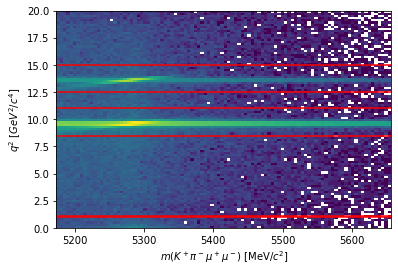

In [33]:
overlay_q2_cuts(total_dataset)

m_inv range [5182.063900339033, 5576.687108537558]
q2_range [0, 20]


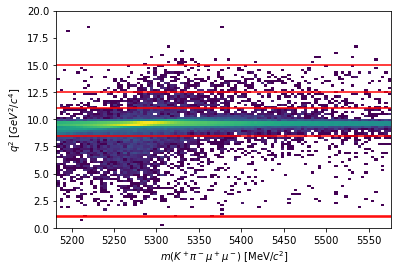

In [34]:
overlay_q2_cuts(jpsi)

m_inv range [5192.285290974594, 5423.804985308397]
q2_range [0, 20]


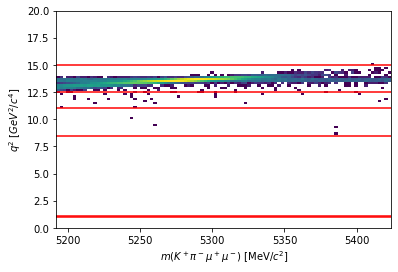

In [35]:
overlay_q2_cuts(psi2S)

In [36]:
benchmark_cut(selection_7)

Total        reduced by 88.15% or 439206 samples 	from 498245 to 59039
Signal       reduced by 33.67% or 86119 samples 	from 255741 to 169622
J/Psi        reduced by 99.50% or 782832 samples 	from 786776 to 3944
Psi(2S)      reduced by 99.96% or 181007 samples 	from 181076 to 69
J/Psi_mu/k   reduced by 47.78% or 949 samples 	from 1986 to 1037
J/Psi_mu/pi  reduced by 34.15% or 264 samples 	from 773 to 509
K0_k/pi      reduced by 34.19% or 45566 samples 	from 133292 to 87726
Phi_mu_mu    reduced by 34.58% or 23625 samples 	from 68318 to 44693
pK_pi/K_k/pi reduced by 22.67% or 328 samples 	from 1447 to 1119
pK_p/pi      reduced by 23.78% or 268 samples 	from 1127 to 859


In [37]:
for cut in cut_q2:
    print('cut q2:', cut)
    selection_7_modified = partial(selection_7, cut_q2=[cut])
    benchmark_cut(selection_7_modified)
    print()

cut q2: [0.98, 1.1]
Total        reduced by 0.07% or 325 samples 	from 498245 to 497920
Signal       reduced by 0.46% or 1185 samples 	from 255741 to 254556
J/Psi        reduced by 0.00% or 2 samples 	from 786776 to 786774
Psi(2S)      reduced by 0.00% or 0 samples 	from 181076 to 181076
J/Psi_mu/k   reduced by 0.05% or 1 samples 	from 1986 to 1985
J/Psi_mu/pi  reduced by 0.00% or 0 samples 	from 773 to 773
K0_k/pi      reduced by 0.45% or 604 samples 	from 133292 to 132688
Phi_mu_mu    reduced by 0.46% or 312 samples 	from 68318 to 68006
pK_pi/K_k/pi reduced by 1.31% or 19 samples 	from 1447 to 1428
pK_p/pi      reduced by 0.80% or 9 samples 	from 1127 to 1118

cut q2: [8.5, 11.0]
Total        reduced by 74.58% or 371615 samples 	from 498245 to 126630
Signal       reduced by 15.54% or 39751 samples 	from 255741 to 215990
J/Psi        reduced by 99.44% or 782405 samples 	from 786776 to 4371
Psi(2S)      reduced by 0.00% or 7 samples 	from 181076 to 181069
J/Psi_mu/k   reduced by 36.46%

### selection 8

$\mathrm{DLL}_{K\pi} = \log(\mathcal{L}_K) - \log(\mathcal{L}_\pi)$

$\mathrm{DLL}_{\mu\pi} = \log(\mathcal{L}_\mu) - \log(\mathcal{L}_\pi)$

In [38]:
# add in DLL columns
def calc_DLL(a, b):
    return np.log(a) - np.log(b)

def add_DLL_KPi(data):
    data['DLL_KPi_K'] = calc_DLL(data['K_MC15TuneV1_ProbNNk'], data['K_MC15TuneV1_ProbNNpi'])
    data['DLL_KPi_Pi'] = calc_DLL(data['Pi_MC15TuneV1_ProbNNk'], data['Pi_MC15TuneV1_ProbNNpi'])

def add_DLL_MuPi(data):
    data['DLL_MuPi_Muplus'] = calc_DLL(data['mu_plus_MC15TuneV1_ProbNNmu'], data['mu_plus_MC15TuneV1_ProbNNpi'])
    data['DLL_MuPi_Muminus'] = calc_DLL(data['mu_minus_MC15TuneV1_ProbNNmu'], data['mu_minus_MC15TuneV1_ProbNNpi'])

for data in all_datasets:
    add_DLL_KPi(data)
    add_DLL_MuPi(data)

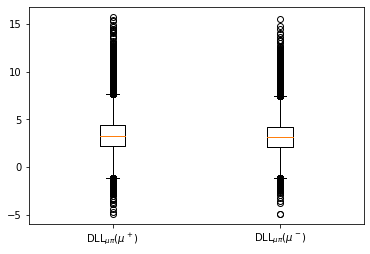

In [39]:
plt.boxplot(signal['DLL_MuPi_Muplus'], labels=[r'$\mathrm{DLL}_{\mu\pi}(\mu^+)$'])
plt.boxplot(signal['DLL_MuPi_Muminus'], positions=[2], labels=[r'$\mathrm{DLL}_{\mu\pi}(\mu^-)$']);

In [40]:
def selection_8(data, DLL_MuPu_thresh=-5):
    data = data[data['DLL_MuPi_Muplus'] > DLL_MuPu_thresh]
    data = data[data['DLL_MuPi_Muminus'] > DLL_MuPu_thresh]
    return data

In [41]:
benchmark_cut(selection_8)

Total        reduced by 0.02% or 95 samples 	from 498245 to 498150
Signal       reduced by 0.00% or 0 samples 	from 255741 to 255741
J/Psi        reduced by 0.00% or 27 samples 	from 786776 to 786749
Psi(2S)      reduced by 0.00% or 0 samples 	from 181076 to 181076
J/Psi_mu/k   reduced by 0.30% or 6 samples 	from 1986 to 1980
J/Psi_mu/pi  reduced by 0.26% or 2 samples 	from 773 to 771
K0_k/pi      reduced by 0.00% or 0 samples 	from 133292 to 133292
Phi_mu_mu    reduced by 0.00% or 0 samples 	from 68318 to 68318
pK_pi/K_k/pi reduced by 0.00% or 0 samples 	from 1447 to 1447
pK_p/pi      reduced by 0.00% or 0 samples 	from 1127 to 1127


### selection 9

5170 < m(K+piu+u-) < 5700

In [42]:
m_B0 = signal['B0_MM']
np.percentile(m_B0, [0.05, 99.95])

array([5171.39572365, 5482.00899873])

In [43]:
def selection_9(data, m_min=5170, m_max=5500):
    data = data[data['B0_MM'] >= m_min]
    data = data[data['B0_MM'] <= m_max]
    return data

In [44]:
benchmark_cut(selection_9)

Total        reduced by 7.05% or 35106 samples 	from 498245 to 463139
Signal       reduced by 0.04% or 111 samples 	from 255741 to 255630
J/Psi        reduced by 2.13% or 16793 samples 	from 786776 to 769983
Psi(2S)      reduced by 0.58% or 1043 samples 	from 181076 to 180033
J/Psi_mu/k   reduced by 2.77% or 55 samples 	from 1986 to 1931
J/Psi_mu/pi  reduced by 0.26% or 2 samples 	from 773 to 771
K0_k/pi      reduced by 2.58% or 3440 samples 	from 133292 to 129852
Phi_mu_mu    reduced by 0.08% or 55 samples 	from 68318 to 68263
pK_pi/K_k/pi reduced by 0.00% or 0 samples 	from 1447 to 1447
pK_p/pi      reduced by 0.27% or 3 samples 	from 1127 to 1124


### total selection

combine all selections, keep all, even ones that don't seem to do anything 

In [45]:
def selection_all(data):
    selections = [selection_1_final] + [eval(f'selection_{i}') for i in range(2, 10)]
    for selection in selections:
        data = selection(data)
    return data

In [46]:
benchmark_cut(selection_all)

Total        reduced by 98.68% or 491686 samples 	from 498245 to 6559
Signal       reduced by 41.31% or 105642 samples 	from 255741 to 150099
J/Psi        reduced by 99.97% or 786542 samples 	from 786776 to 234
Psi(2S)      reduced by 99.98% or 181043 samples 	from 181076 to 33
J/Psi_mu/k   reduced by 99.09% or 1968 samples 	from 1986 to 18
J/Psi_mu/pi  reduced by 88.49% or 684 samples 	from 773 to 89
K0_k/pi      reduced by 98.01% or 130642 samples 	from 133292 to 2650
Phi_mu_mu    reduced by 91.65% or 62615 samples 	from 68318 to 5703
pK_pi/K_k/pi reduced by 92.88% or 1344 samples 	from 1447 to 103
pK_p/pi      reduced by 91.04% or 1026 samples 	from 1127 to 101


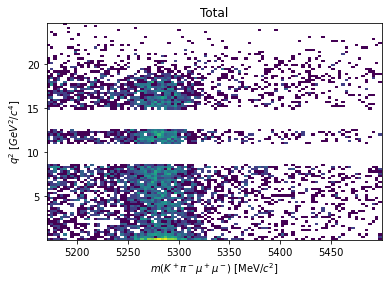

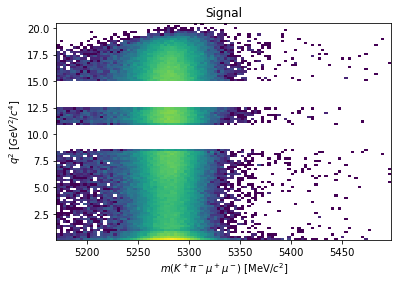

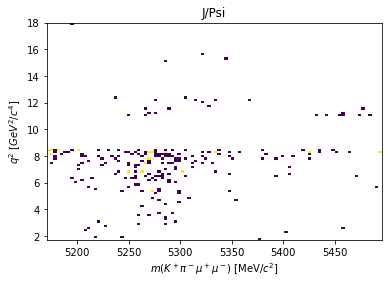

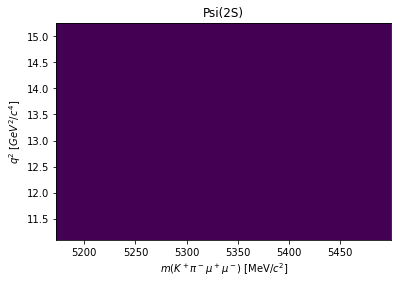

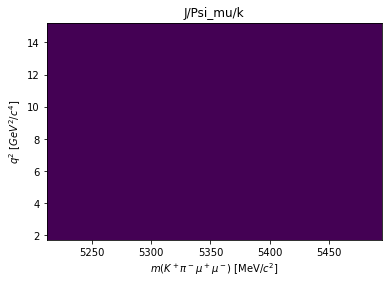

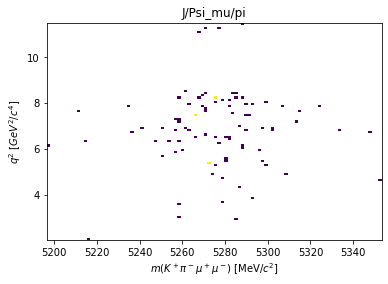

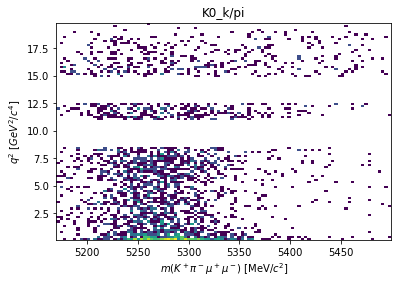

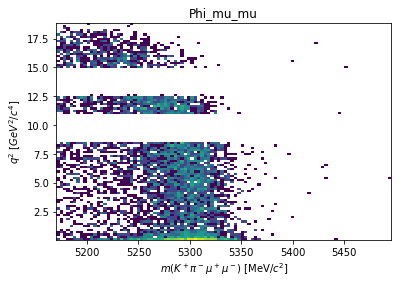

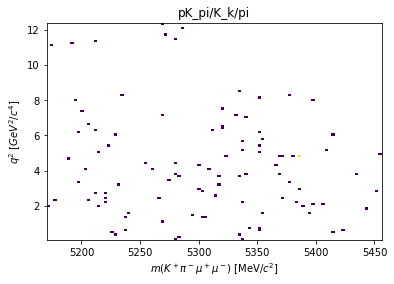

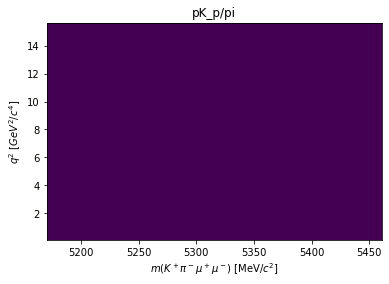

In [47]:
for name, data in zip(all_names, all_datasets):
    plot_q2_m_inv(selection_all(data), set_range=False)
    plt.title(name)
    plt.show()

## decision tree

In [48]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import plot_tree

In [49]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV

### construct combined dataset

1. add labels to each dataset
2. concatenate datasets 
3. split into train + test 

In [50]:
# total momentum + transverse
def add_B0_momentums(data):
    particles = ['mu_plus', 'mu_minus', 'K', 'Pi']
    data['B0_PT'] = sum(data[s + '_PT'] for s in particles)
    data['B0_P'] = sum(data[s + '_P'] for s in particles)

for data in all_datasets:
    add_B0_momentums(data)

In [51]:
train_datasets, train_names = all_datasets[1:], all_names[1:] # exclude total_dataset

for i in [1, 2]:
    print('Applied q2 cut on', train_names[i])
    train_datasets[i] = selection_7(train_datasets[i])

for name, data in zip(train_names, train_datasets):
    decay_type = pd.Categorical([name]*len(data), categories=train_names, ordered=True)
    data['decay_type'] = decay_type

Applied q2 cut on J/Psi
Applied q2 cut on Psi(2S)


In [52]:
# columns to keep 
column_labels = ['decay_type'] # training labels 

columns_keep_train = ['DLL_KPi_K', 'DLL_KPi_Pi', 'DLL_MuPi_Muplus', 'DLL_MuPi_Muminus'] # DLL vars
columns_keep_train += ['B0_IPCHI2_OWNPV', 'B0_DIRA_OWNPV'] # B0 chi2 + DIRA
columns_keep_train += ['B0_PT', 'B0_P'] # B0 momentums
columns_keep = column_labels + columns_keep_train

In [53]:
# columns_remove = ['decay_type', 'q2', 'phi', 'costhetal', 'costhetak']
# columns_remove += ['B0_MM', 'B0_ID', 'polarity', 'year']
# columns_remove += [s + '_ENDVERTEX_NDOF' for s in ['B0', 'Kstar', 'J_psi']]
# columns_remove += ['B0_OWNPV_' + s for s in ['X', 'Y', 'Z']]
# columns_keep_train = list(set(signal.columns) - set(columns_remove))
# columns_keep = column_labels + columns_keep_train
# sorted(columns_keep_train)

In [54]:
train_datasets_reduced = (data[columns_keep] for data in train_datasets)
datasets_concat = pd.concat(train_datasets_reduced, ignore_index=True)

datasets_concat.shape

(466697, 9)

In [55]:
# del signal
# del jpsi
# del psi2S
# del jpsi_mu_k_swap
# del jpsi_mu_pi_swap
# del k_pi_swap
# del phimumu
# del pKmumu_piTok_kTop
# del pKmumu_piTop
# del all_datasets

### generate test + train dataset

In [56]:
rng = np.random.RandomState(42) # need to rerun after each training for reproducibility 

In [57]:
X, y = datasets_concat[columns_keep_train], datasets_concat[column_labels[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, stratify=y)

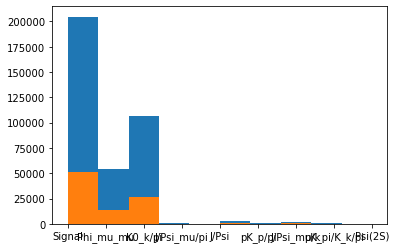

In [58]:
# verify that distribution of labels the same 
plt.hist(y_train)
plt.hist(y_test);

### do fitting

In [59]:
# hyperparameter search, takes a few minutes to run 

# clf = HistGradientBoostingClassifier(random_state=rng)

# params_distr = {
#     'learning_rate': sps.uniform(loc=0.08, scale=0.4),
#     'max_iter': [50, 100, 150, 200, 250],
#     'l2_regularization': sps.uniform(loc=0, scale=0.2)
# }
# search = HalvingRandomSearchCV(clf, params_distr, factor=3, max_resources=20000,
#                                random_state=rng, verbose=2, n_jobs=2).fit(X_train, y_train)

# print(search.best_params_)

In [60]:
# search_best_params = {'l2_regularization': 0.01, 'learning_rate': 0.15, 'max_iter': 100}
# search_best_params = {'l2_regularization': 0.002, 'learning_rate': 0.12, 'max_iter': 120}
search_best_params = {'l2_regularization': 0.18416714021091232, 'learning_rate': 0.1450747407932629, 'max_iter': 250} # best so far 

clf = HistGradientBoostingClassifier(**search_best_params, random_state=rng)

In [61]:
# cross-validate with KFolds
skf = StratifiedKFold(n_splits=10)

all_scores_cross_val = []
for i, (idx_train, idx_test) in enumerate(skf.split(X_train, y_train)): 
    #if i > 1:
    #    break
    
    clf.fit(X_train.iloc[idx_train], y_train.iloc[idx_train])
    score = clf.score(X_train.iloc[idx_test], y_train.iloc[idx_test])
    all_scores_cross_val.append(score)
    print(f'{i}th fold: {score*100:.3f}%')
print()
print(f'Avg score: {np.mean(all_scores_cross_val)*100:.3f}%')

0th fold: 94.303%
1th fold: 94.424%
2th fold: 94.378%
3th fold: 94.217%
4th fold: 94.461%
5th fold: 94.354%
6th fold: 94.408%
7th fold: 94.357%
8th fold: 94.354%
9th fold: 94.316%

Avg score: 94.357%


In [62]:
clf.fit(X_train, y_train)
print(f'Final evaluation: {clf.score(X_test, y_test)*100:.3f}% accuracy')

Final evaluation: 94.424% accuracy


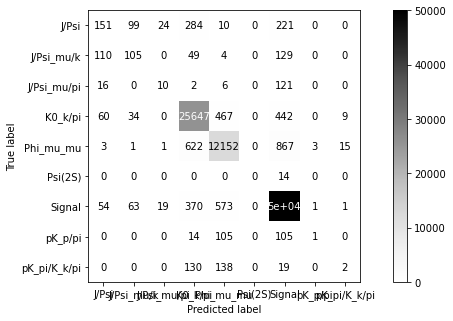

In [63]:
fig, ax = plt.subplots(figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Greys', ax=ax)

In [64]:
cm_predict = confusion_matrix(y_test, clf.predict(X_test), labels=train_names)
n_labels = cm_predict.shape[0]
for i in range(n_labels):
    n_correct = cm_predict[i,i]
    n_wrong = np.sum(cm_predict[i,np.arange(n_labels) != i])
    f_correct = n_correct / (n_correct + n_wrong)
    n_wrong_signal = cm_predict[i,0]
    name_space = "".join([" "]*(12-len(train_names[i])))
    print(f'{train_names[i]}:{name_space} {f_correct*100:.3f}% correct, {n_wrong}/{n_correct + n_wrong} wrong; {n_wrong_signal} wrongly labeled as signal')

Signal:       97.887% correct, 1081/51148 wrong; 50067 wrongly labeled as signal
J/Psi:        19.138% correct, 638/789 wrong; 221 wrongly labeled as signal
Psi(2S):      0.000% correct, 14/14 wrong; 14 wrongly labeled as signal
J/Psi_mu/k:   26.448% correct, 292/397 wrong; 129 wrongly labeled as signal
J/Psi_mu/pi:  6.452% correct, 145/155 wrong; 121 wrongly labeled as signal
K0_k/pi:      96.204% correct, 1012/26659 wrong; 442 wrongly labeled as signal
Phi_mu_mu:    88.934% correct, 1512/13664 wrong; 867 wrongly labeled as signal
pK_pi/K_k/pi: 0.692% correct, 287/289 wrong; 19 wrongly labeled as signal
pK_p/pi:      0.444% correct, 224/225 wrong; 105 wrongly labeled as signal


### create selection function

In [65]:
def selection_dt(data):
    data_ = data[columns_keep_train]
    if len(data_) == 0:
        return data
    y = clf.predict(data_)
    return data[y == 'Signal']

In [66]:
benchmark_cut(selection_dt)

Total        reduced by 44.13% or 219860 samples 	from 498245 to 278385
Signal       reduced by 1.92% or 4913 samples 	from 255741 to 250828
J/Psi        reduced by 35.72% or 281043 samples 	from 786776 to 505733
Psi(2S)      reduced by 1.97% or 3575 samples 	from 181076 to 177501
J/Psi_mu/k   reduced by 69.94% or 1389 samples 	from 1986 to 597
J/Psi_mu/pi  reduced by 29.50% or 228 samples 	from 773 to 545
K0_k/pi      reduced by 98.33% or 131063 samples 	from 133292 to 2229
Phi_mu_mu    reduced by 93.99% or 64215 samples 	from 68318 to 4103
pK_pi/K_k/pi reduced by 93.37% or 1351 samples 	from 1447 to 96
pK_p/pi      reduced by 54.21% or 611 samples 	from 1127 to 516


## combined: hard cuts + decision tree

In [67]:
def selection_all_dt(data):
    data = selection_all(data)
    data = selection_dt(data)
    return data

In [68]:
print('After hard cuts')
benchmark_cut(selection_all)

After hard cuts
Total        reduced by 98.68% or 491686 samples 	from 498245 to 6559
Signal       reduced by 41.31% or 105642 samples 	from 255741 to 150099
J/Psi        reduced by 99.97% or 786542 samples 	from 786776 to 234
Psi(2S)      reduced by 99.98% or 181043 samples 	from 181076 to 33
J/Psi_mu/k   reduced by 99.09% or 1968 samples 	from 1986 to 18
J/Psi_mu/pi  reduced by 88.49% or 684 samples 	from 773 to 89
K0_k/pi      reduced by 98.01% or 130642 samples 	from 133292 to 2650
Phi_mu_mu    reduced by 91.65% or 62615 samples 	from 68318 to 5703
pK_pi/K_k/pi reduced by 92.88% or 1344 samples 	from 1447 to 103
pK_p/pi      reduced by 91.04% or 1026 samples 	from 1127 to 101


In [69]:
print('After hard cuts + decision tree')
benchmark_cut(selection_all_dt)

After hard cuts + decision tree
Total        reduced by 98.82% or 492352 samples 	from 498245 to 5893
Signal       reduced by 41.82% or 106961 samples 	from 255741 to 148780
J/Psi        reduced by 99.97% or 786578 samples 	from 786776 to 198
Psi(2S)      reduced by 99.99% or 181065 samples 	from 181076 to 11
J/Psi_mu/k   reduced by 99.14% or 1969 samples 	from 1986 to 17
J/Psi_mu/pi  reduced by 90.30% or 698 samples 	from 773 to 75
K0_k/pi      reduced by 99.30% or 132363 samples 	from 133292 to 929
Phi_mu_mu    reduced by 96.45% or 65894 samples 	from 68318 to 2424
pK_pi/K_k/pi reduced by 96.68% or 1399 samples 	from 1447 to 48
pK_p/pi      reduced by 92.81% or 1046 samples 	from 1127 to 81


In [70]:
total_dataset_all = selection_all(total_dataset)
total_dataset_all_dt = selection_all_dt(total_dataset)

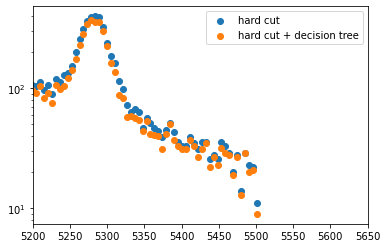

In [71]:
# visualise effect of cuts on data 

# hist_point(total_dataset['B0_MM'], range=(5170, 5700), bins=100, label='unprocessed')
hist_point(total_dataset_all['B0_MM'], range=(5170, 5700), bins=100, label='hard cut')
hist_point(total_dataset_all_dt['B0_MM'], range=(5170, 5700), bins=100, label='hard cut + decision tree')
plt.xlim(5200, 5650)
plt.yscale('log')
plt.legend()

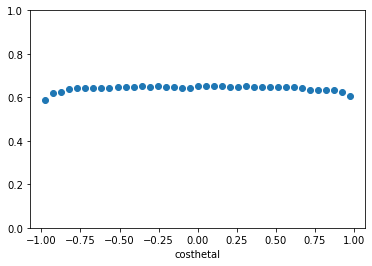

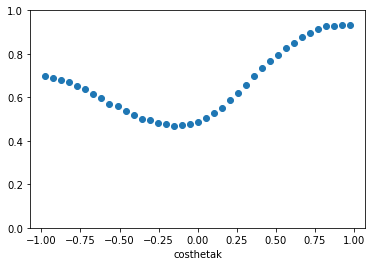

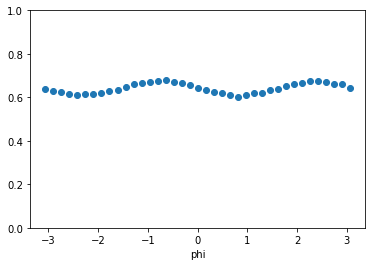

In [72]:
jpsi_dt = selection_dt(jpsi)

for cl in ['costhetal', 'costhetak', 'phi']:
    if cl == 'phi':
        bins = np.linspace(-np.pi, np.pi, 40)
    else:
        bins = np.linspace(-1, 1, 40)
    
    h_jpsi, _ = np.histogram(jpsi[cl], bins=bins)
    h_jpsi_dt, _ = np.histogram(jpsi_dt[cl], bins=bins)

    bin_centres = (bins[:-1] + bins[1:]) / 2
    plt.scatter(bin_centres, h_jpsi_dt / h_jpsi)
    plt.ylim(0, 1)
    plt.xlabel(cl)
    plt.show()

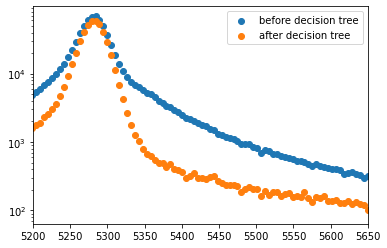

In [73]:
hist_point(jpsi['B0_MM'], range=(5170, 5700), bins=100, label='before decision tree')
hist_point(jpsi_dt['B0_MM'], range=(5170, 5700), bins=100, label='after decision tree')
plt.xlim(5200, 5650)
plt.yscale('log')
plt.legend()

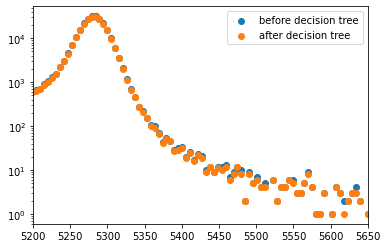

In [74]:
signal_dt = selection_dt(signal)

hist_point(signal['B0_MM'], range=(5170, 5700), bins=100, label='before decision tree')
hist_point(signal_dt['B0_MM'], range=(5170, 5700), bins=100, label='after decision tree')
plt.xlim(5200, 5650)
plt.yscale('log')
plt.legend()

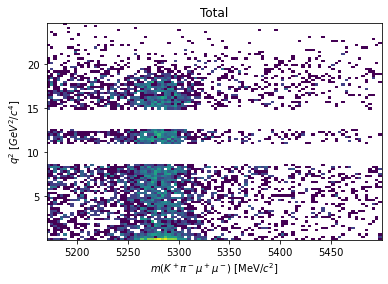

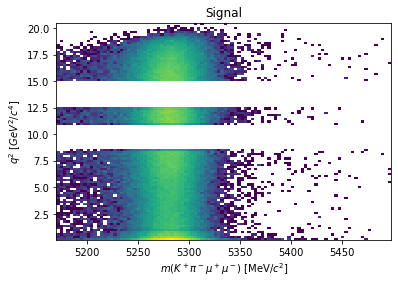

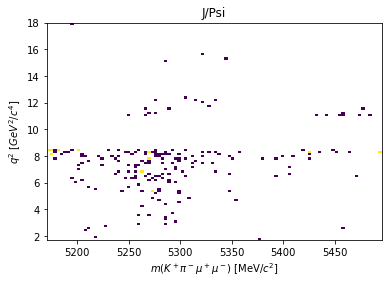

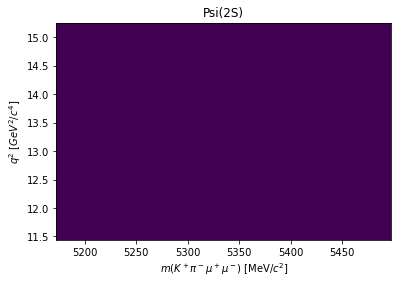

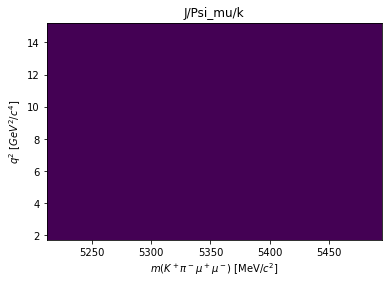

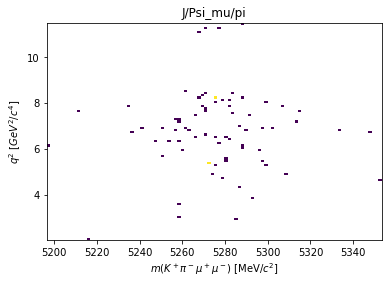

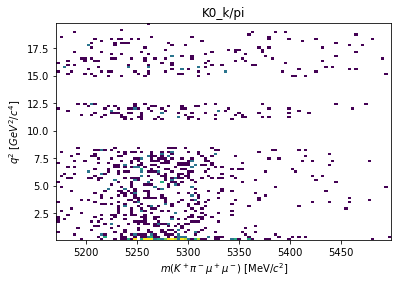

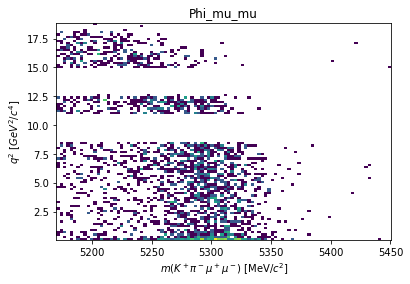

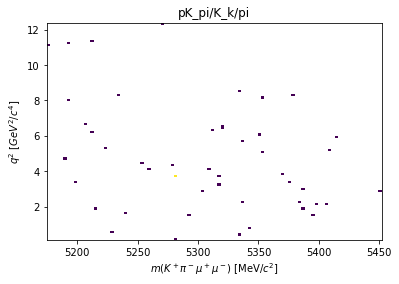

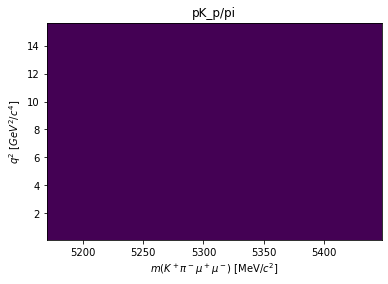

In [75]:
for name, data in zip(all_names, all_datasets):
    plot_q2_m_inv(selection_all_dt(data), set_range=False)
    plt.title(name)
    plt.show()

## estimate composition of dataset

In [76]:
def calc_percentage_cut(data, selection):
    N_before = len(data)
    data = selection(data)
    N_after = len(data)
    return (N_before - N_after) / N_before

In [77]:
def selection_7_JPsi(data):
    cut = cut_q2[1]
    return selection_7(data, cut_q2=[cut])

def selection_7_Psi2S(data):
    cut = cut_q2[2]
    return selection_7(data, cut_q2=[cut])

In [78]:
f_JPsi = calc_percentage_cut(total_dataset, selection_7_JPsi)
f_Psi2S = calc_percentage_cut(total_dataset, selection_7_Psi2S)
print(f'J/Psi fraction: {f_JPsi*100:.3f}%')
print(f'Psi(2S) fraction: {f_Psi2S*100:.3f}%')

J/Psi fraction: 74.585%
Psi(2S) fraction: 13.501%


J/Psi:        1.252%
J/Psi_mu/k:   0.511%
J/Psi_mu/pi:  0.024%
K0_k/pi:      4.226%
Phi_mu_mu:    0.875%
Psi(2S):      0.002%
Signal:       4.942%
pK_p/pi:      0.006%
pK_pi/K_k/pi: 0.011%


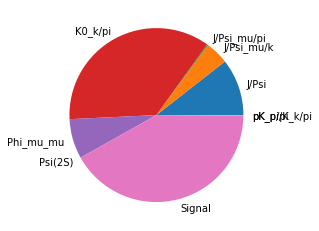

In [79]:
f_JPsi_Psi2S = calc_percentage_cut(total_dataset, selection_7)
f_rest = 1 - f_JPsi_Psi2S

total_dataset_labels = clf.predict(selection_7(total_dataset)[columns_keep_train])
decay_names, N_classified = np.unique(total_dataset_labels, return_counts=True)
plt.pie(N_classified, labels=decay_names)

N_classified_total = np.sum(N_classified)
f_all = {}
for name, N in zip(decay_names, N_classified):
    name_space = "".join([" "]*(12-len(name)))
    f = N / N_classified_total * f_rest
    f_all[name] = f
    print(f'{name}:{name_space} {f * 100:.3f}%')

In [80]:
f_all['J/Psi'] = f_JPsi
f_all['Psi(2S)'] = f_Psi2S

In [81]:
f_all

{'J/Psi': 0.7458479262210358,
 'J/Psi_mu/k': 0.005113949964374954,
 'J/Psi_mu/pi': 0.00023683127778502533,
 'K0_k/pi': 0.04226434786099206,
 'Phi_mu_mu': 0.008748707964956996,
 'Psi(2S)': 0.13500587060582644,
 'Signal': 0.049421469357444604,
 'pK_p/pi': 6.221838653674394e-05,
 'pK_pi/K_k/pi': 0.00010637337053056223}

In [82]:
print('frac_total_dataset (from DT) x frac_misclassify = frac_err_whole_dataset')
print()
N_after_selection_all_dt = len(total_dataset_all_dt)
for name, data in zip(all_names[1:], all_datasets[1:]):
    f_misclassified = 1 - calc_percentage_cut(data, selection_all_dt)
    f_err = f_all[name] * f_misclassified
    name_space = "".join([" "]*(12-len(name)))
    print(f'{name}:{name_space} {f_all[name]*100:.2f}% x {f_misclassified*100:.2f}% = {f_err*100:.4f}%, abs {f_err*N_after_selection_all_dt:.4f}')

frac_total_dataset (from DT) x frac_misclassify = frac_err_whole_dataset

Signal:       4.94% x 58.18% = 2.8751%, abs 169.4323
J/Psi:        74.58% x 0.03% = 0.0188%, abs 1.1061
Psi(2S):      13.50% x 0.01% = 0.0008%, abs 0.0483
J/Psi_mu/k:   0.51% x 0.86% = 0.0044%, abs 0.2580
J/Psi_mu/pi:  0.02% x 9.70% = 0.0023%, abs 0.1354
K0_k/pi:      4.23% x 0.70% = 0.0295%, abs 1.7359
Phi_mu_mu:    0.87% x 3.55% = 0.0310%, abs 1.8293
pK_pi/K_k/pi: 0.01% x 3.32% = 0.0004%, abs 0.0208
pK_p/pi:      0.01% x 7.19% = 0.0004%, abs 0.0264


In [83]:
print('frac_total_dataset (from simulation) x frac_misclassify = frac_err_whole_dataset')
print()
N_after_selection_all_dt = len(total_dataset_all_dt)
N_total = sum(len(data) for data in all_datasets[1:])
for name, data in zip(all_names[1:], all_datasets[1:]):
    f_misclassified = 1 - calc_percentage_cut(data, selection_all_dt)
    f_err = len(data) / N_total * f_misclassified
    name_space = "".join([" "]*(12-len(name)))
    print(f'{name}:{name_space} {len(data) / N_total*100:.2f}% x {f_misclassified*100:.2f}% = {f_err*100:.4f}%, abs {f_err*N_after_selection_all_dt:.4f}')

frac_total_dataset (from simulation) x frac_misclassify = frac_err_whole_dataset

Signal:       17.88% x 58.18% = 10.4003%, abs 612.8895
J/Psi:        55.00% x 0.03% = 0.0138%, abs 0.8156
Psi(2S):      12.66% x 0.01% = 0.0008%, abs 0.0453
J/Psi_mu/k:   0.14% x 0.86% = 0.0012%, abs 0.0700
J/Psi_mu/pi:  0.05% x 9.70% = 0.0052%, abs 0.3090
K0_k/pi:      9.32% x 0.70% = 0.0649%, abs 3.8270
Phi_mu_mu:    4.78% x 3.55% = 0.1694%, abs 9.9855
pK_pi/K_k/pi: 0.10% x 3.32% = 0.0034%, abs 0.1977
pK_p/pi:      0.08% x 7.19% = 0.0057%, abs 0.3337


## estimate variance on misclassification

## acceptance dataset 

In [84]:
acceptance_path = f'{data_path}/acceptance_mc.pkl'
acceptance = pd.read_pickle(acceptance_path)

# add calculated columns
add_B0_momentums(acceptance)
add_DLL_KPi(acceptance)
add_DLL_MuPi(acceptance)

In [85]:
acceptance_all_dt = selection_all_dt(acceptance)
N_before = len(acceptance)
N_after = len(acceptance_all_dt)
print(f'before: {N_before}, after: {N_after}; diff: {N_before - N_after}')

before: 716859, after: 430900; diff: 285959


## save classified datasets

In [86]:
f_dir = './final_data_processed/'
def save_df(fn, data):
    # only save needed columns
    data = data[['B0_MM', 'Kstar_MM', 'J_psi_MM', 'q2', \
                 'phi', 'costhetal', 'costhetak']]
    data.to_pickle(f_dir + fn + '.pkl')

In [88]:
# save_df('total_dataset_classified', total_dataset_all_dt)
# save_df('acceptance_classified', acceptance_all_dt)